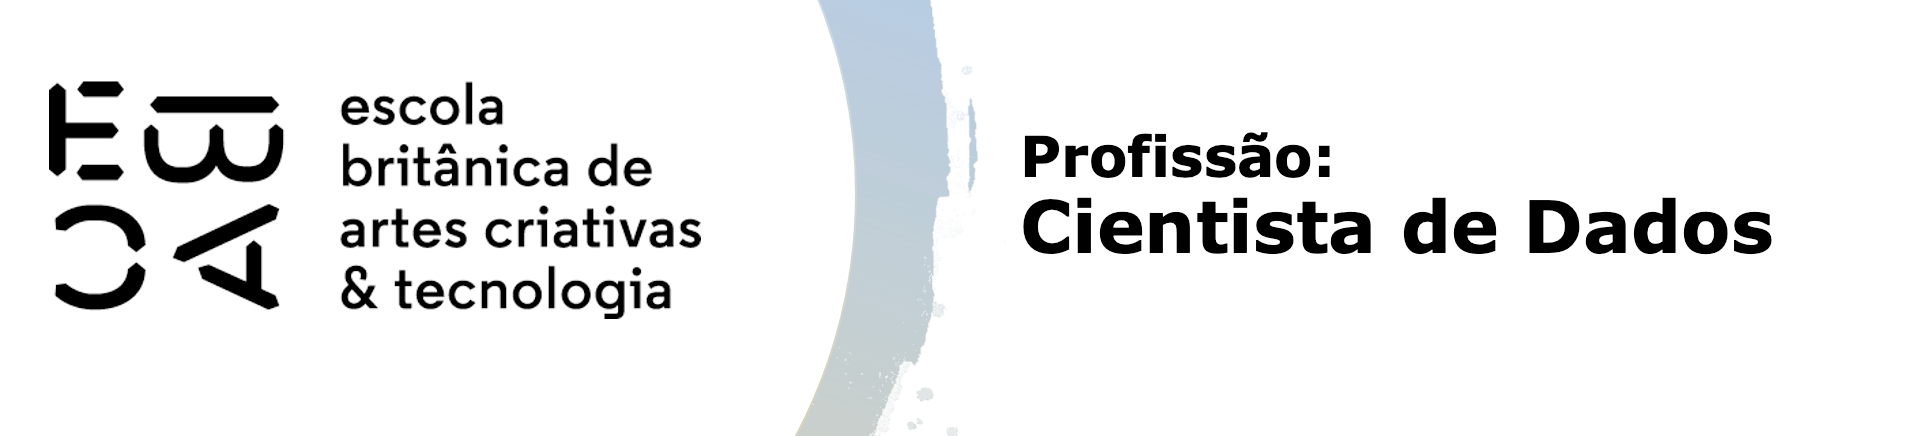

# Bibliotecas

In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec


from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, auc,recall_score, precision_score

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.preprocessing import LabelEncoder, PowerTransformer, OneHotEncoder
# from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from imblearn.under_sampling import RandomUnderSampler

from ydata_profiling import ProfileReport
import statsmodels.api as sm
from scipy.stats import t

# Dados

In [2]:
def importar():
    dt = pd.read_feather("C:\\Users\\alcid\\GitHub\\Portfolio\\EBAC\\Dados\\credit_scoring_small.ftr")
    ID = dt.pop("index")
    dt['mes'] = dt['data_ref'].dt.month
    dt = dt.drop(axis=0, columns=['data_ref'])
    display(dt.head())
    return dt

In [3]:
df = importar()

sexo posse_de_veiculo posse_de_imovel  qtd_filhos   tipo_renda  \
0    F                N               N           0   Empresário   
1    F                S               S           0  Assalariado   
2    F                N               N           2  Assalariado   
3    F                N               N           0  Assalariado   
4    F                S               N           0  Assalariado   

              educacao estado_civil tipo_residencia  idade  tempo_emprego  \
0                Médio     Solteiro            Casa     43       6.873973   
1                Médio       Casado            Casa     35       4.526027   
2                Médio       Casado            Casa     31       0.243836   
3                Médio       Casado            Casa     54      12.772603   
4  Superior incompleto     Solteiro            Casa     31       8.432877   

   qt_pessoas_residencia     renda    mau  mes  
0                    1.0   2515.39  False    1  
1                    2.0   3180.19  False    1  
2                    4.0   1582.29  False    1  
3                    2.0  13721.17  False    1  
4                    1.0   2891.08  False    1

## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [4]:
data = df.sample(frac=0.95, random_state=786)
data_unseen = df.drop(data.index)
data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)
print(f"Dados de treino/teste tem o seguinte tamanho {data.shape}")
print(f"Dados de validação tem o seguinte tamanho {data_unseen.shape}")

Dados de treino/teste tem o seguinte tamanho (712500, 14)
Dados de validação tem o seguinte tamanho (37500, 14)


## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

<div style="background-color: #f0f0f0; padding: 10px; border: 1px solid #ddd;border-radius: 10px">
    O uso da biblioteca ProfileReport ajuda muito na análise dos dados, visto que é capaz de averiguar individualmente como cada variável se comporta.

In [5]:
ProfileReport(data)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

<div style="background-color: #f0f0f0; padding: 10px; border: 1px solid #ddd;border-radius: 10px">
  
A análise da significância estatística é considerada um procedimento para verificar a discrepância de uma hipótese estatística em relação aos dados observados, utilizando uma medida de evidência. Aqui a abordagem será para averiguar a significância de cada variável em relação a prever se é BOM ou MAU pagador, como threshould padrão utilizados por pesquisadores, assumiremos o valor de 0.20, se for abaixo disso vai ter significância estatística, caso contrário será descartada

In [7]:
def analise_individual(dt, entrada, alvo):
    X = dt[entrada].copy()
    print(f"{entrada} iniciado.")
    if X.isnull().sum() > 0:
        X = X.fillna(X.mean())

        
    y = dt[alvo].copy()
    
    if X.dtype == 'O':
        X = LabelEncoder().fit_transform(X)
        
    
    modelo = sm.Logit(y, X)
    resultado = modelo.fit(disp=False)
    
    
    
    return resultado.pvalues

In [8]:
resultados = []
for i in data:
    resultados.append([i,analise_individual(data, i,'mau')[0]])

sexo iniciado.
posse_de_veiculo iniciado.
posse_de_imovel iniciado.
qtd_filhos iniciado.
tipo_renda iniciado.
educacao iniciado.
estado_civil iniciado.
tipo_residencia iniciado.
idade iniciado.
tempo_emprego iniciado.
qt_pessoas_residencia iniciado.
renda iniciado.


C:\Users\alcid\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


mau iniciado.


C:\Users\alcid\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


mes iniciado.


In [9]:
resultados = pd.DataFrame(resultados, columns=['Variável','Significância'])
resultados

Variável  Significância
0                    sexo       0.000000
1        posse_de_veiculo       0.000000
2         posse_de_imovel       0.000000
3              qtd_filhos       0.000000
4              tipo_renda       0.000000
5                educacao       0.000000
6            estado_civil       0.000000
7         tipo_residencia       0.000000
8                   idade       0.000000
9           tempo_emprego       0.000000
10  qt_pessoas_residencia       0.000000
11                  renda       0.000000
12                    mau       0.978871
13                    mes       0.000000

<div style="background-color: #f0f0f0; padding: 10px; border: 1px solid #ddd;border-radius: 10px">
    A análise preliminar demonstrou que todos os atributos tem uma importância para a previsão do modelo.

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.


#### Avaliação de zero estruturais

In [19]:
class bivariada:
    def __init__(self, variavel=None, resposta=None):
        try:
            self.iv = self.IV(variavel, resposta)
        except:
            self.iv = None
            
            
            
    def IV(self,variavel, resposta):
        tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

        rótulo_evento = tab.columns[0]
        rótulo_nao_evento = tab.columns[1]

        tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
        tab['ep'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]

        tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
        tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
        tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
        return tab['iv_parcial'].sum()
    
    
    
    def biv_discreta(self, var, dt):
        dados = dt.copy()
        if dados[var].nunique() > 12:
            dados.loc[:,var] = pd.qcut(dados[var], 5).astype(str)
        dados['bom'] = 1-dados.mau
        g = dados.groupby(var)

        biv = pd.DataFrame({'qt_bom': g['bom'].sum(), # Total of reliable payers
                            'qt_mau': g['mau'].sum(), # Total of unreliable payers
                            'mau':g['mau'].mean(), 
                            var: g['mau'].mean().index, 
                            'cont':g[var].count()})

        biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
        # Using the scipy library to estimate the confidence interval.
        biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep 
        biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep


        biv['logit'] = np.log(biv.mau/(1-biv.mau))
        biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
        biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

        tx_mau_geral = df.mau.mean()
        woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

        biv['woe'] = biv.logit - woe_geral
        biv['woe_sup'] = biv.logit_sup - woe_geral
        biv['woe_inf'] = biv.logit_inf - woe_geral

        return biv
    
    def grafico(self,colunas, dados):
        
        dt = dados.copy()
        tamanho = (7, 2)
        figura = plt.figure(figsize=(10,30))
        plt.suptitle('Gráfico de Correlação Bivariada (WOE)',y=.94, fontsize=30)
        outer = gridspec.GridSpec(7, 2, height_ratios=[1, 1, 1, 1, 1, 1, 1], hspace=0.4, wspace=0.4)
        c = 0


        for row in range(tamanho[0]):
            for col in range(tamanho[1]):
                column = colunas[c]
                biv = bivariada().biv_discreta(column, dt)

                inner = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[row, col], hspace=0.1)

                if c == 12:
                    inner = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[row, col:], hspace=0.1)
                    ax = plt.Subplot(figura, inner[0, 0:])
                    figura.add_subplot(ax)
                    plt.title(column)
                    ax.plot(biv[column], biv.woe, ':bo', label='woe')
                    ax.plot(biv[column], biv.woe_sup, 'o:r', label='limite superior')
                    ax.plot(biv[column], biv.woe_inf, 'o:r', label='limite inferior')
                    handles, labels = ax.get_legend_handles_labels()
                    figura.legend(handles, labels, bbox_to_anchor=(0.5, 0.91), loc='upper center', ncol=3)

                    ax.spines['bottom'].set_visible(False)
                    ax.set_xticks([])
                    ax.set_xlabel('')
                    ax.set_ylabel("Weight of Evidence", fontsize=8)
                    
                    ax = plt.Subplot(figura,  inner[1, 0:])
                    figura.add_subplot(ax)
                    ax.spines['top'].set_visible(False) 
                    ax = biv.cont.plot.bar()
                    plt.xticks(rotation=360)
                    ax.set_xlabel('')
                    ax.set_ylabel("Frequency", fontsize=8)
                    break

                ax = plt.Subplot(figura, inner[0])
                figura.add_subplot(ax)
                plt.title(column)
                ax.plot(biv[column], biv.woe, ':bo', label='woe')
                ax.plot(biv[column], biv.woe_sup, 'o:r', label='limite superior')
                ax.plot(biv[column], biv.woe_inf, 'o:r', label='limite inferior')
                num_cat = biv.shape[0]
                ax.set_xlim([-.3, num_cat-.7])
                ax.set_ylabel("Weight of Evidence", fontsize=8)
                

                ax.spines['bottom'].set_visible(False)
                ax.set_xticks([])
                ax.set_xlabel('')

                ax = plt.Subplot(figura, inner[1])
                figura.add_subplot(ax)
                ax.spines['top'].set_visible(False)
                ax = biv.cont.plot.bar()
                plt.xticks(rotation=30, fontsize=7)
                ax.set_xlabel('')
                ax.set_ylabel("Frequency", fontsize=8)

                c += 1
                
        
        return plt.show()

In [14]:
independente = data.columns.tolist()
independente.remove('mau')
tabela = []
for col in independente:
    if data[col].nunique()>12:
        iv = bivariada(pd.qcut(data[col], 5, duplicates='drop'), data['mau']).iv
        tabela.append([col, iv])
    else:
        iv = bivariada(data[col], data['mau']).iv
        tabela.append([col, iv])
        
tabela = pd.DataFrame(tabela, columns=['variavel','iv']).set_index('variavel')
print("\n\nValor do IV para cada variável independente")
display(tabela)



Valor do IV para cada variável independente


iv
variavel                       
sexo                   0.002245
posse_de_veiculo       0.000102
posse_de_imovel        0.009796
qtd_filhos             0.001619
tipo_renda             0.009229
educacao               0.003395
estado_civil           0.001041
tipo_residencia        0.003003
idade                  0.018030
tempo_emprego          0.350593
qt_pessoas_residencia       inf
renda                  1.066825
mes                    0.346780

C:\Users\alcid\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\alcid\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\alcid\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


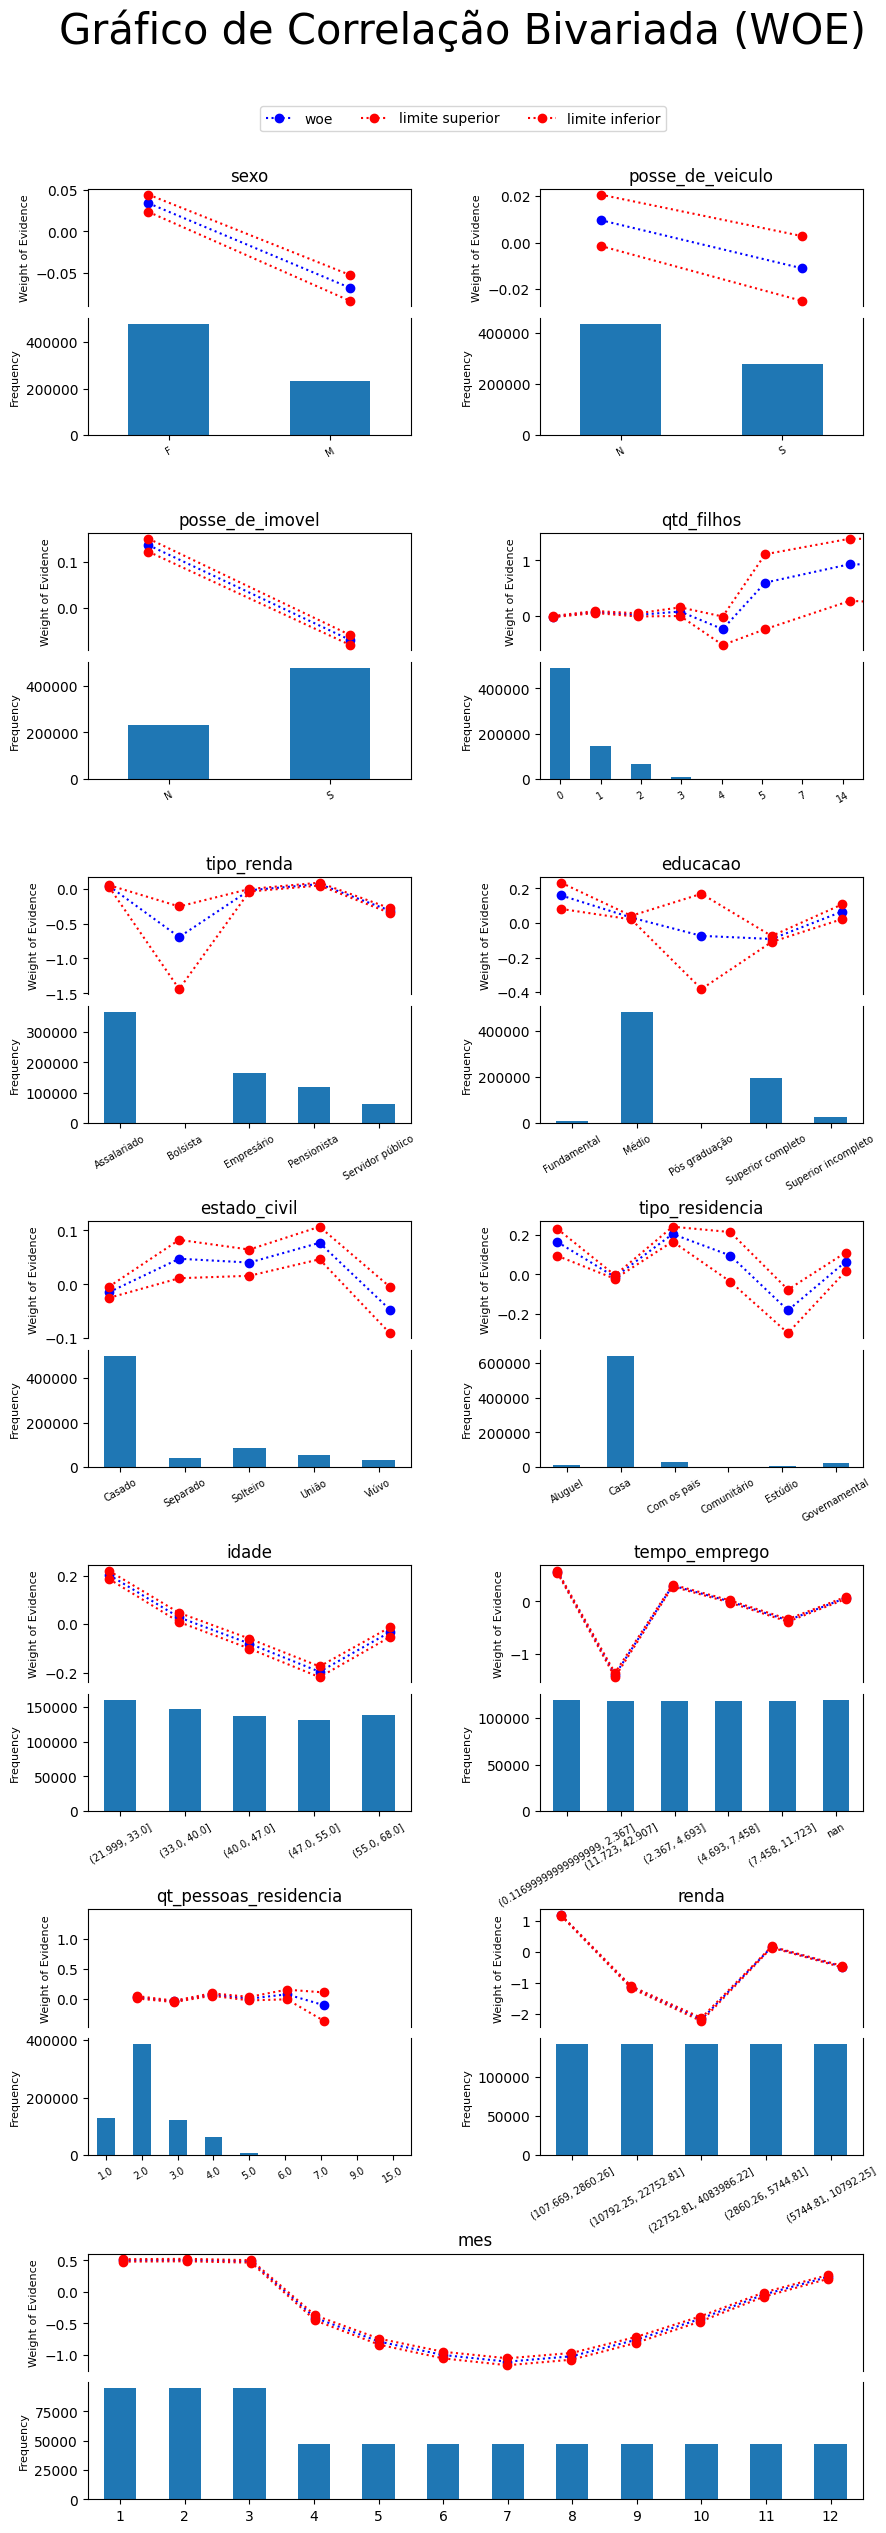

In [23]:
bivariada().grafico(independente, data)

<div style="background-color: #f0f0f0; padding: 10px; border: 1px solid #ddd;border-radius: 10px">

#### Explicação Sobre o Gráfico Acima
Intervalo de Confiança Amplo (Largo): Indica que há uma maior incerteza em torno do valor estimado de WOE para essa categoria. Pode ser resultado de uma amostra pequena, alta variabilidade nos dados ou outros fatores que contribuem para a incerteza na estimativa.

Intervalo de Confiança Curto (Estreito): Indica que a estimativa de WOE é mais precisa e há menor incerteza associada a ela. Pode ocorrer quando você tem uma amostra grande e/ou baixa variabilidade nos dados.

Weight of Evidence (WOE) - é uma métrica frequentemente utilizada em modelagem de crédito e análise de risco para avaliar a força de relação entre uma variável independente categórica e a variável dependente binária


WOE Positivo: Se o WOE é positivo, isso indica uma relação positiva com a variável dependente. Isso sugere que a categoria tem maior probabilidade de estar associada ao evento de interesse (por exemplo, inadimplência em um empréstimo).
WOE Negativo: Se o WOE é negativo, isso indica uma relação negativa com a variável dependente. Nesse caso, a categoria tem menor probabilidade de estar associada ao evento de interesse.
WOE Próximo a Zero: Um WOE próximo a zero sugere que a categoria tem uma probabilidade de evento semelhante à média geral. Pode ser interpretado como uma categoria "neutra" em termos de sua influência na variável dependente.
WOE Infinito ou Indefinido: Se uma categoria tem zero eventos em uma das classes (por exemplo, nenhuma inadimplência), o WOE será indefinido ou infinito.

#### Analisando dados.
   Com base na explicação anterior, podemos assumis que diversas categorias apresentam uma ampla faixa de WOE, demonstrando que há uma ampla variação, sendo então prudênte a realização da absorção dessas categorias raras por outras mais representadas.
    

In [87]:
def tratamento(dt):
    dados = dt.copy()
    
    # Ajustando categorias raras 
    dados.loc[dados['qtd_filhos'] >= 3, 'qtd_filhos'] = 3
    dados.loc[dados['qt_pessoas_residencia'] >= 5, 'qt_pessoas_residencia'] = 5
    dados.loc[(dados['tipo_residencia'] != "Casa") & (dados['tipo_residencia'] != "Governamental"), 'tipo_residencia'] = 'outros'
    dados.loc[dados['tipo_renda'] == 'Bolsista','tipo_renda'] = 'Pensionista'
    dados.loc[dados['educacao'] == 'Pós graduação','educacao'] = 'Superior completo'
    
    # Preenchendo Vazios 
    preencher = data.isnull().sum()[data.isnull().sum() > 0].index[0]
    dados[preencher] = dados[preencher].fillna(dados[preencher].mean())
    
    # Normalização dos dados
    pt = PowerTransformer(method='yeo-johnson', standardize=True)
    for col in ['renda','tempo_emprego']:
        dados[col] = pt.fit_transform(dados[col].values.reshape(-1, 1)).reshape(-1) # Transformação para passar no programa e para votlar aos dados
    
    return dados

In [88]:
data_tratado = tratamento(data)

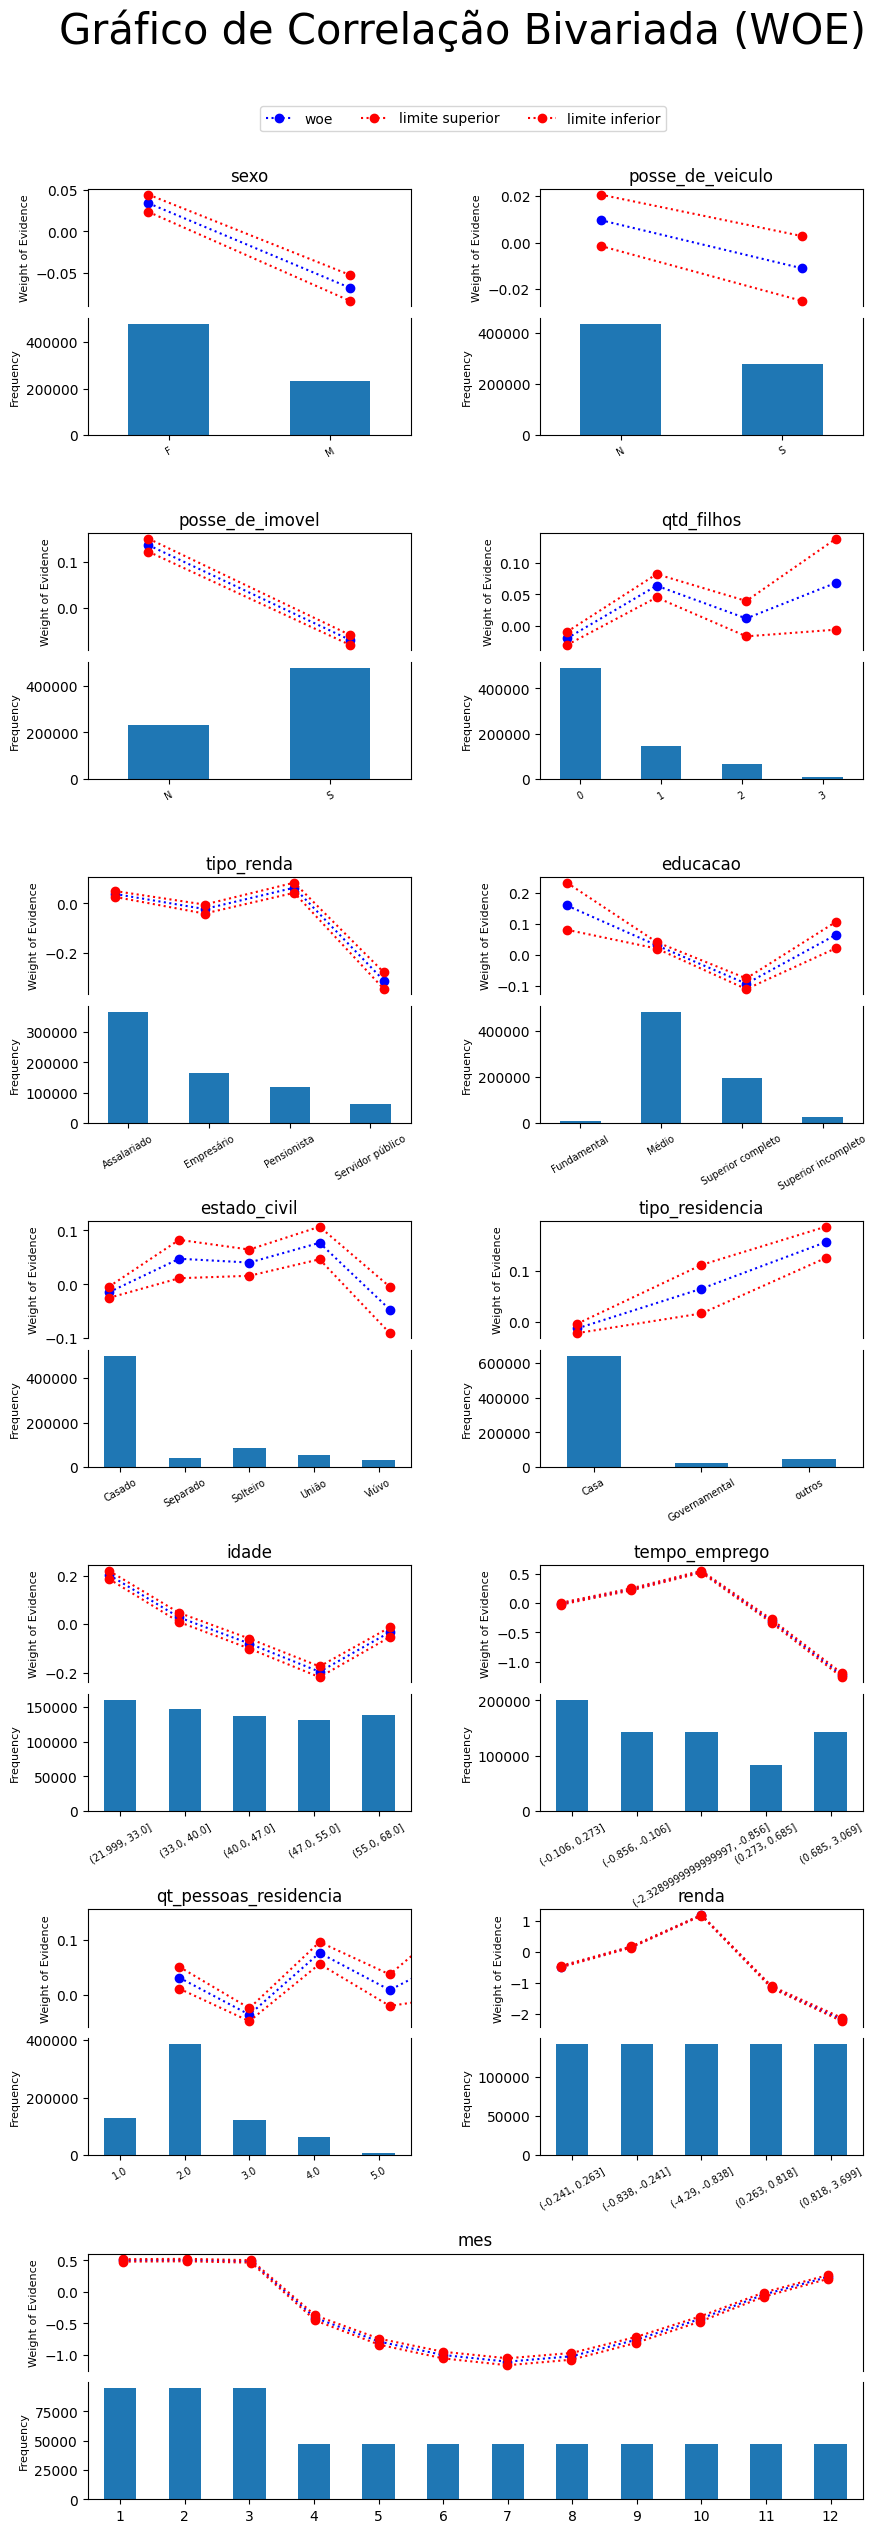

In [89]:
bivariada().grafico(independente, data_tratado)

<div style="background-color: #f0f0f0; padding: 10px; border: 1px solid #ddd;border-radius: 10px">
    
#### Analisando a transformação dos dados
    
Observa-se que a discrepância demonstrada na imagem anterior a essa, acabou sendo desfeita, com as classes apresentando um maior equilibrio sobre o range da distribuição de cada categória para a previsão da classificação. 

In [127]:
def modelo_logit(dt):
    X = dt.copy()
    y = X.pop('mau')
    y = y.map({True:1,False:0})
    

    for col in X.select_dtypes(exclude=np.number):
        X[col] = LabelEncoder().fit_transform(X[col])
    
    modelo = sm.Logit(y, X)
    resultado = modelo.fit(disp=False)
    
    y_pred = resultado.predict(X)
    
    acuracia = accuracy_score(y, (y_pred > 0.5).astype(int))
    recall = recall_score(y,  (y_pred > 0.5).astype(int))
    precision = precision_score(y,  (y_pred > 0.5).astype(int))
    fpr, tpr, thresholds = roc_curve(y, y_pred)
    ks = max(tpr - fpr)
    gini = 2 * auc(fpr, tpr) - 1
    auc_score = auc(fpr, tpr)
    
    print(f"Acurácia: {acuracia*100:.2f} %", )
    print(f"KS: {ks*100:.2f}", )
    print(f"Gini: {gini*100:.2f}")
    print(f"Recall: {recall*100:.2f}")
    print(f"Precision: {precision*100:.2f}")
    
    cm = confusion_matrix(y, (y_pred > 0.5).astype(int))

    # Heatmap da Matriz de Confusão
    figura = plt.figure(figsize=(10, 4))

    plt.subplot2grid((1,2), (0,0))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=['Pred Bom', 'Pred Mau'],
                yticklabels=['Actual Bom', 'Actual Mau'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')



    plt.subplot2grid((1,2), (0,1))
        # Curva ROC
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc_score))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')

    plt.show()

    
    return resultado.summary().tables[1]

Acurácia: 92.16 %
KS: 39.99
Gini: 54.02
Recall: 3.84
Precision: 49.48


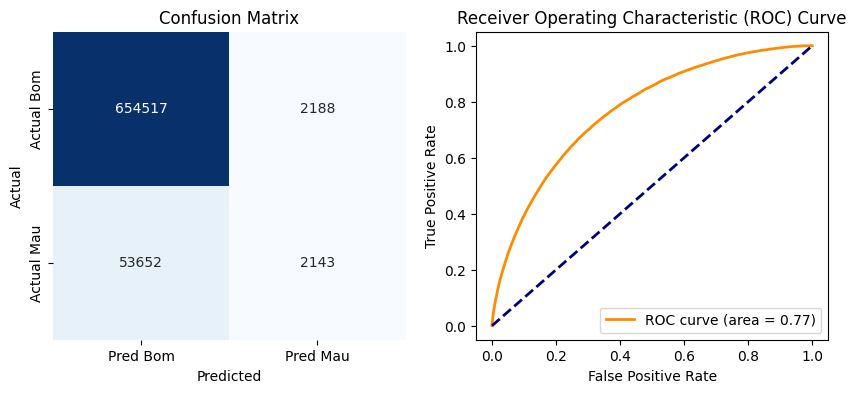

<class 'statsmodels.iolib.table.SimpleTable'>

In [128]:
modelo_logit(data_tratado)

<div style="background-color: #f0f0f0; padding: 10px; border: 1px solid #ddd;border-radius: 10px">

#### Acurácia: 92.16%

A acurácia representa a porcentagem de previsões corretas feitas pelo modelo. No caso presente, o modelo atingiu uma taxa de acurácia de 92.16%, indicando uma boa capacidade geral de fazer previsões corretas.
#### KS (Kolmogorov-Smirnov): 39.99

O KS é uma métrica que avalia a capacidade do modelo em separar as classes positivas e negativas. Um valor maior de KS sugere uma melhor capacidade de discriminação. O valor de 39.99 indica uma distinção robusta entre as classes.
#### Gini: 54.02

O índice de Gini mede a área entre a curva ROC (Receiver Operating Characteristic) e a linha de referência. Um valor mais alto de Gini sugere um melhor desempenho do modelo. Neste caso, o modelo obteve um índice de Gini de 54.02, indicando uma boa capacidade de classificação.
#### Recall: 3.84%

O recall (ou sensibilidade) mede a capacidade do modelo em identificar corretamente todas as instâncias positivas. O valor de 3.84% indica que o modelo tem uma baixa taxa de verdadeiros positivos em relação ao total de casos positivos.
#### Precision: 49.48%
    
A precisão mede a proporção de instâncias positivas corretamente identificadas em relação ao total de instâncias identificadas como positivas. Neste caso, a precisão é de 49.48%, sugerindo que, das instâncias identificadas como positivas, aproximadamente metade é verdadeira.
    
#### Conclusão sobre o modelo.
O modelo gerado com base exclusíva dos dados, utilizando o modelo de regressão logística, alcançou um resultado fraco, com uma baixa classificação correta dos maus pagadores. As alternativas possíveis vão desde aplicação de feature engineering, para tentar captar novas relações e transformações dos dados que facilitem o modelo à alcançar um melhor resultado, até a adptação de modelos mais robustos. 
    
Avaliando agora a importância de cada classe na classificação, a única que não mostrou uma relevância para o modelo foi a posse de veículo, podendo ser excluída sem alterar o modelo. 


## Criar um pipeline utilizando o sklearn pipeline 

### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)


### Criar funções personalizadas
1. **Balanceamento** - A funçaõ irá utilizar a técnica Random Under Sampler para poder balanceador os dados, básicamente vai escolher dados aleatórios para igualar a quantidade das classes peditivas.

2. **Tratamento_zero** - Irá tratar os zeros estruturais.

3. **Modelo** - O modelo será construído e exportado por essa funçaõ, além de avaliar os resultados através das métricas usadas anteriormente

In [227]:
   
### Função para Balanceamento
class Balanceamento(BaseEstimator,TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        rus = RandomUnderSampler(random_state=42)
        X_ = X.copy()
        y_ = X_.pop('mau')

        X_resampled, y_resampled = rus.fit_resample(X_, y_)
        X_resampled['mau'] = y_resampled

        return X_resampled
    
### Função para tratar os Zeros estruturais
class tratamento_zero(BaseEstimator,TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, dt):
        X = dt.copy()
        X.loc[X['qtd_filhos'] >= 3, 'qtd_filhos'] = 3
        X.loc[X['qt_pessoas_residencia'] >= 5, 'qt_pessoas_residencia'] = 5
        X.loc[(X['tipo_residencia'] != "Casa") & (X['tipo_residencia'] != "Governamental"), 'tipo_residencia'] = 'outros'
        X.loc[X['tipo_renda'] == 'Bolsista','tipo_renda'] = 'Pensionista'
        X.loc[X['educacao'] == 'Pós graduação','educacao'] = 'Superior completo'
        return X
    
def modelo(dt):
    X_transformed = pipe.fit_transform(data)
    feature_names = preprocessor.get_feature_names_out()

    # Criando um DataFrame com as colunas transformadas
    X_transformed_df = pd.DataFrame.sparse.from_spmatrix(X_transformed, columns=feature_names)
    y = X_transformed_df.pop('cat__mau_True')

    
    model = sm.Logit(y, X_transformed_df)
    resultado = model.fit(disp=False)
    
    y_pred = resultado.predict(X_transformed_df)
    
    acuracia = accuracy_score(y, (y_pred > 0.5).astype(int))
    recall = recall_score(y,  (y_pred > 0.5).astype(int))
    precision = precision_score(y,  (y_pred > 0.5).astype(int))
    fpr, tpr, thresholds = roc_curve(y, y_pred)
    ks = max(tpr - fpr)
    gini = 2 * auc(fpr, tpr) - 1
    auc_score = auc(fpr, tpr)
    
    print(f"Acurácia: {acuracia*100:.2f} %", )
    print(f"KS: {ks*100:.2f}", )
    print(f"Gini: {gini*100:.2f}")
    print(f"Recall: {recall*100:.2f}")
    print(f"Precision: {precision*100:.2f}")
    
    cm = confusion_matrix(y, (y_pred > 0.5).astype(int))

    # Heatmap da Matriz de Confusão
    figura = plt.figure(figsize=(10, 4))

    plt.subplot2grid((1,2), (0,0))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=['Pred Bom', 'Pred Mau'],
                yticklabels=['Actual Bom', 'Actual Mau'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')



    plt.subplot2grid((1,2), (0,1))
        # Curva ROC
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc_score))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')

    plt.show()
    
    return model

### Main Pipeline

1. Os atributos numéricos e categóricos definidos para entrar passar a sequência de pipelines. De forma simples, o primeiro pipe criado é para o tratamento dos dados numéricos, preenchendo os vazios e transformando os dados. O segundo pipe é juntando no mesmo processo o tratamento numérico anterior com o tratamento de one hot encoder nos categóricos. O terceiro e o pipe principal irá por no mesmo processo os pipes anteriores junto com as funções personalizadas.

In [230]:
categorical_cols = data.select_dtypes(exclude=np.number).columns.tolist()
num =  list(set(data.columns) - set(categorical_cols))
numeric_cols = num.copy()
for col in num:
    if data[col].nunique() < 15:
        categorical_cols.append(col)
        numeric_cols.remove(col)
        

numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('power_transformer', PowerTransformer(method='yeo-johnson', standardize=False))
    ])

           
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
        
    ]
)

pipe = Pipeline(steps=[
    ('balanceamento',Balanceamento()), 
    ('tratamento',tratamento_zero()),
    ('preprocessamento', preprocessor),
])


### Modelo de previsão
Modelo criado e os resultados do modelo estão plotados abaixo.

Acurácia: 70.64 %
KS: 41.42
Gini: 56.01
Recall: 70.86
Precision: 70.55


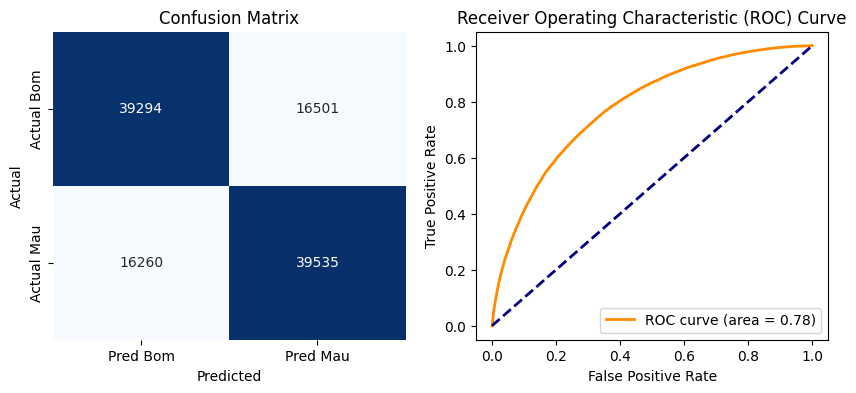

In [231]:
model = modelo(data)

### Salvar o pickle file do modelo treinado

In [232]:
import pickle

nome_arquivo = 'model_final.pkl'
pickle.dump(model, open(nome_arquivo, 'wb'))

# Projeto Final

1. Subir no GITHUB todos os jupyter notebooks/códigos que você desenvolveu nesse ultimo módulo
1. Gerar um arquivo python (.py) com todas as funções necessárias para rodar no streamlit a escoragem do arquivo de treino
    - Criar um .py
    - Criar um carregador de csv no streamlit 
    - Subir um csv no streamlit 
    - Criar um pipeline de pré processamento dos dados
    - Utilizar o modelo treinado para escorar a base 
        - nome_arquivo = 'model_final.pkl'
1. Gravar um vídeo da tela do streamlit em funcionamento (usando o próprio streamlit (temos aula disso) ou qlqr outra forma de gravação).
1. Subir no Github o vídeo de funcionamento da ferramenta como README.md.
1. Subir no Github os códigos desenvolvidos. 
1. Enviar links do github para o tutor corrigir.